<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite Differences - Taylor Operators and Numerical Differentiation</div>
        </div>
    </div>
</div>

<p style="width:20%;float:right;padding-left:50px">
<img src=../../share/images/book.jpg>
<span style="font-size:smaller">
</span>
</p>


---

This notebook is part of the supplementary material 
to [Computational Seismology: A Practical Introduction](https://global.oup.com/academic/product/computational-seismology-9780198717416?cc=de&lang=en&#), 
Oxford University Press, 2016.


##### Authors:
* Lion Krischer ([@krischer](https://github.com/krischer))
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))
---

This exercise covers the following aspects:

* Use the Taylor series to calculate finite-difference operators
* Learn how to define high-order finite-difference operators
* Demonstrate the accuracy improvement by testing the operators on (arbitrary) functions

---

## Basic Equations

The Taylor expansion of $f(x + dx)$ around $x$ is defined as 

$$
f(x+dx)=\sum_{n=0}^\infty \frac{f^{(n)}(x)}{n!}dx^{n}  
$$


Finite-difference operators can be calculated by seeking weights (here: $a$, $b$, $c$) with which function values have to be multiplied to obtain an interpolation or a derivative. Example:

$$
\begin{align}
a ~ f(x + dx) & \ = \ a ~ \left[ ~  f(x) +  f^{'} (x) dx +  \frac{1}{2!}  f^{''} (x) dx^2   + \dotsc  ~ \right] \\
b ~ f(x) & \  = \ b ~ \left[ ~  f(x)  ~ \right] \\
c ~ f(x - dx) & \ = \ c ~ \left[ ~  f(x) -  f^{'} (x) dx +  \frac{1}{2!}  f^{''} (x) dx^2   - \dotsc  ~ \right]
\end{align}
$$

This can  be expressed in matrix form by comparing coefficients, here seeking a 2nd derivative

$$
\begin{align}
&a  ~~+~~            ~~~~b           &+~~  c & = & 0 \\
&a  ~~\phantom{+}~~ \phantom{b}  &-~~  c & = & 0 \\
&a  ~~\phantom{+}~~ \phantom{b}  &+~~  c & = & \frac{2!}{\mathrm{d}x^2}
\end{align}
$$

which leads to 

$$
\begin{pmatrix}
  1 & 1 & 1 \\
  1 & 0 & -1 \\
  1 & 0 & 1
 \end{pmatrix}
\begin{pmatrix}
  a\\
 b \\
 c
 \end{pmatrix}
 =
 \begin{pmatrix}
  0\\
 0 \\
 \frac{2!}{dx^2}
 \end{pmatrix}
$$

and using matrix inversion we obtain 

$$
\begin{pmatrix}
a \\
b\\
c
\end{pmatrix}
=
\begin{pmatrix}
\frac{1}{2 \mathrm{d}x^2} \\
 - \frac{2}{2 \mathrm{d}x^2} \\
  \frac{1}{2 \mathrm{d}x^2}
\end{pmatrix}
$$

This is the the well known 3-point operator for the 2nd derivative. This can easily be generalized to higher point operators and higher order derivatives. Below you will find a routine that initializes the system matrix and solves for the Taylor operator. 

---

## Calculating the Taylor operator

The subroutine `central_difference_coefficients()` initalizes the system matrix and solves for the difference weights assuming $dx=1$. It calculates the centered differences using an arbitrary number of coefficients, also for higher derivatives. The weights are defined at $x\pm i dx$ and $i=0,..,(nop-1)/2$, where $nop$ is the length of the operator. Careful! Because it is centered $nop$ has to be an odd number (3,5,...)!

It returns a central finite difference stencil (a vector of length $nop$)  for the `n`th derivative.

In [1]:
import math
import numpy as np


def central_difference_coefficients(nop, n):
    """
    Calculate the central finite difference stencil for an arbitrary number
    of points and an arbitrary order derivative.
    
    :param nop: The number of points for the stencil. Must be
        an odd number.
    :param n: The derivative order. Must be a positive number.
    """
    m = np.zeros((nop, nop))
    for i in range(nop):
        for j in range(nop):
            dx = j - nop // 2
            m[i, j] = dx ** i
    
    s = np.zeros(nop)
    s[n] = math.factorial(n)
    
    # The following statement return oper = inv(m) s
    oper = np.linalg.solve(m, s)
    # Calculate operator
    return oper

---

## Plot Taylor operators

Investigate graphically the Taylor operators. Increase $nop$ for the first $n=1$ or higher order derivatives. Discuss the results and try to understand the interpolation operator (derivative order $n=0$).

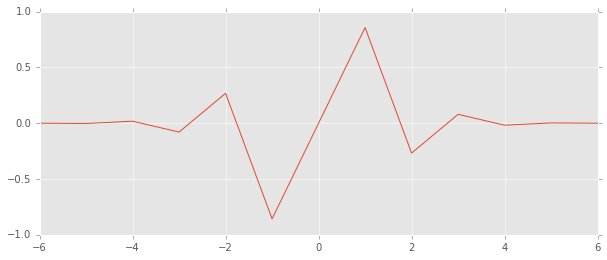

In [2]:
%matplotlib inline

# Some necessary initialization
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Give length of operator (odd)
nop = 13
# Give order of derivative (0 - interpolation, 1 - first derivative, 2 - second derivative)
n = 1

# Get operator from routine 'central_difference_coefficients'
oper = central_difference_coefficients(nop, n)

# Initialize location of operator
x = np.linspace(-(nop - 1) / 2, (nop - 1) / 2, nop)

# Simple plot with operator
plt.figure(figsize=(10, 4))
plt.plot(x, oper)
plt.show()

---

## Accuracy of centered finite differences

Define a simple function, e.g. sine, cosine, gaussian, some polynomial, ..., differentiate it using the stencils returned from the above function and compare the result to the analytically calculated derivative. Keep the physical domain (e.g., 3$\pi$) constant but change 1) the number of points nx (i.e., change dx) or 2) change the wavenumber k. In both cases you change the number of grid points per wavelength. Calculate the error of the solution (in the center of the domain) and look at the error as a function of grid points per wavelength. 

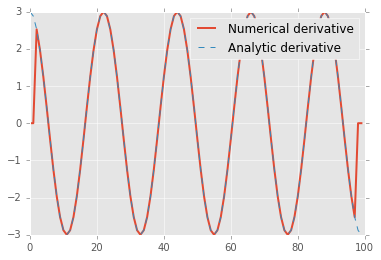

In [3]:
# Let us initialize space between 0 and 10 pi with 10000 points
# Note: here you can be creative, change the function as you like, 
# as long as you know the analytical derivative 
nx = 100        # Number of points in x
x = np.linspace(0, 3 * np.pi, nx)

# We initialite a function f as a sin curve with wavenumber k
k = 3
f = np.sin(k * x)

# The analytical derivative is given by
dfa = k * np.cos(k * x)

# We need to know the grid spacing dx 
dx = x[2] - x[1]

# Now let's get the finite difference operator with paramters
nop = 5 # Length of operator
n = 1   #  1 st derivative
oper = central_difference_coefficients(nop, n)

# Calculate the derivative of f(x) by applying the finite-difference operator
df = np.zeros(nx)
# Loop over the central points where we calculate the derivatives
for i in range(nop // 2, nx - nop // 2):  # Avoid the boundaries
    # Loop over operator
    for j in range(0, nop):  
       df[i] = df[i] + oper[j] * f[i - (nop - 1) // 2 + j]
           
# Scale by dx.
df /= dx ** n

plt.plot(df, label="Numerical derivative", lw=2)
plt.plot(dfa, ls="--",label="Analytic derivative")
plt.legend()
plt.show()